# ***Predicting Proposal Success - 04 - Modelling***

**Purpose:** The RFS and Non-RFS proposal data is modelled with the goal of finding an optimal model with ***interpretable and explainable*** results

**Summary of Findings:**
For both models, the best results were seen with logistic regression models. Neither models perform particularly well, although that was expected given the lack of data on the pricing on competitve bids. The Non-RFS model acheived an accuracy rate of 73%, while the RFS model was accuracte 68% of the time.

**Next Steps:** The model is evaluated in detail to extract meaningful business insights for the client

# **File Setup**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

import io
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
X_train_all = pd.read_pickle('/content/drive/My Drive/shared_folder/X_train_all.pkl')
X_test_all = pd.read_pickle('/content/drive/My Drive/shared_folder/X_test_all.pkl')
y_train_all = pd.read_pickle('/content/drive/My Drive/shared_folder/y_train_all.pkl')
y_test_all = pd.read_pickle('/content/drive/My Drive/shared_folder/y_test_all.pkl')

X_train_rfs = pd.read_pickle('/content/drive/My Drive/shared_folder/X_train_rfs.pkl')
X_test_rfs = pd.read_pickle('/content/drive/My Drive/shared_folder/X_test_rfs.pkl')
y_train_rfs = pd.read_pickle('/content/drive/My Drive/shared_folder/y_train_rfs.pkl')
y_test_rfs = pd.read_pickle('/content/drive/My Drive/shared_folder/y_test_rfs.pkl')

In [ ]:
print('Non-RFS')
print('X_train:', X_train_all.shape)
print('y_train:', y_train_all.shape)
print('X_test:', X_test_all.shape)
print('y_test:', y_test_all.shape)
print('RFS')
print('X_train:', X_train_rfs.shape)
print('y_train:', y_train_rfs.shape)
print('X_test:', X_test_rfs.shape)
print('y_test:', y_test_rfs.shape)

Non-RFS
X_train: (1345, 34)
y_train: (1345,)
X_test: (337, 34)
y_test: (337,)
RFS
X_train: (1096, 40)
y_train: (1096,)
X_test: (274, 40)
y_test: (274,)


In [ ]:
#Removing an index column that should not be included in modelling
#X_train_all = X_train_all.drop(columns=['Unnamed: 0'])
#X_test_all = X_test_all.drop(columns=['Unnamed: 0'])

Our outcome (y) was balanced between the two classes during EDA, but let's just confirm the lack of inbalance before starting

In [ ]:
print('Non-RFS: ', y_train_all.value_counts())
print('RFS: ', y_train_rfs.value_counts())

Non-RFS:  outcome
1    746
0    599
Name: count, dtype: int64
RFS:  outcome
0    588
1    508
Name: count, dtype: int64


# **Non-RFS Model - Logistic Regression**

We're going to start with Logistic Regression using a Lasso penalty to try and get a simpler list of important features

In [ ]:
logreg = LogisticRegression()

param_grid = {
    'C': [0.1, 1.0, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'max_iter': [100, 150, 200],
}

grid_search = GridSearchCV(logreg, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_all, y_train_all)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}


In [ ]:
logreg = LogisticRegression(C=10, max_iter = 100, penalty='l2', solver='liblinear')
logreg.fit(X_train_all, y_train_all)
y_pred_logreg_all = logreg.predict(X_test_all)
y_pred_logreg_all_probs = logreg.predict_proba(X_test_all)
y_pred_logreg_all_probs = y_pred_logreg_all_probs[:,1]

The results are ok at 73%. It at least passes the 70% threshold, but not by much

AUC Score: 0.730433


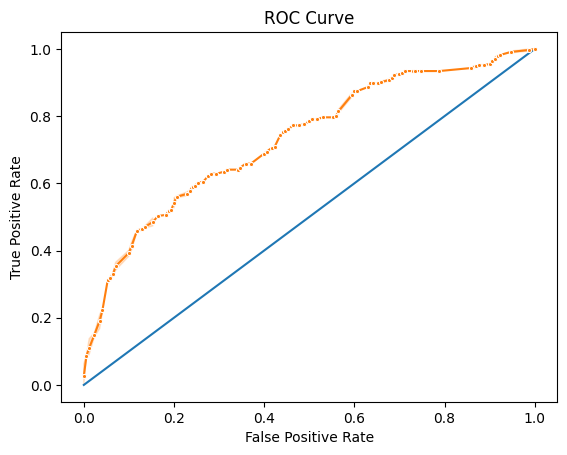

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_all, y_pred_logreg_all_probs)
sns.lineplot(x=[0,1], y=[0,1], linestyle='-')
ax = sns.lineplot(x=fpr, y=tpr, marker = '.')
ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

auc_score = roc_auc_score(y_test_all, y_pred_logreg_all_probs)
print('AUC Score: %3f' %auc_score)

Based on the confusion matrix, performance is skewed with a higher false positive rate vs false negative rate.

In [ ]:
confusion_matrix(y_test_all, y_pred_logreg_all)

array([[ 87,  83],
       [ 38, 129]])

In [ ]:
print('Precision: ', precision_score(y_test_all, y_pred_logreg_all))
print('Recall: ', recall_score(y_test_all, y_pred_logreg_all))

Precision:  0.6084905660377359
Recall:  0.7724550898203593


Out of curiousity, lets do a quick check on the features being used

In [ ]:
coefficients = logreg.coef_[0]
feature_names = X_train_all.columns

coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

coeff_df['Abs_Coefficient'] = coeff_df['Coefficient'].abs()
coeff_df = coeff_df.sort_values(by='Abs_Coefficient', ascending=False)

print(coeff_df)

                          Feature  Coefficient  Abs_Coefficient
24                          fee_0     1.331820         1.331820
21                      region_PC    -1.064925         1.064925
33                          fee_9    -0.760525         0.760525
22                     region_TOR    -0.695438         0.695438
26                          fee_2     0.657875         0.657875
19                     region_HUR    -0.647528         0.647528
11                        sow_PCA     0.628713         0.628713
25                          fee_1     0.612511         0.612511
17                      region_EO     0.511225         0.511225
18                      region_GH    -0.462428         0.462428
7                  sow_Mechanical     0.442313         0.442313
23                      region_YR    -0.434569         0.434569
2                   sow_BCA & RFS    -0.412932         0.412932
9            sow_PA & Class 1 RFS    -0.397872         0.397872
15                    sow_Roofing     0.

# **Non-RFS Model - Classification Tree**

We're using the entropy criterion since we want informative results over balanced trees

In [ ]:
dt_all = DecisionTreeClassifier(criterion = 'entropy', random_state=37)
dt_all.fit(X_train_all, y_train_all)
y_pred_dt_all = dt_all.predict(X_test_all)

The performance is weaker than the logistic regression, coming in under the 70% mark

In [ ]:
accuracy_score(y_test_all, y_pred_dt_all)

0.6795252225519288

Setting a max_depth has a significant impact on score

In [ ]:
param_grid = {'max_depth': [5, 10, 15, 20]}
dt_all_grid = GridSearchCV(dt_all, param_grid, cv=5)
dt_all_grid.fit(X_train_all, y_train_all)

print(dt_all_grid.best_params_)
print(dt_all_grid.best_score_)

{'max_depth': 10}
0.6118959107806692


# **Non-RFS Model - Random Forest**

Interestingly, our random forest has a slightly worse score than our single classification tree. Maybe a boosted decision tree would be a better fit

In [ ]:
rf_all = RandomForestClassifier(criterion = 'entropy', random_state=37)
rf_all.fit(X_train_all, y_train_all)
y_pred_rf_all = rf_all.predict(X_test_all)

print('Accuracy: ', accuracy_score(y_test_all, y_pred_rf_all))

Accuracy:  0.6528189910979229


The feature importance here is fairly similar to what we saw in the logistic regresssion model.

<Axes: >

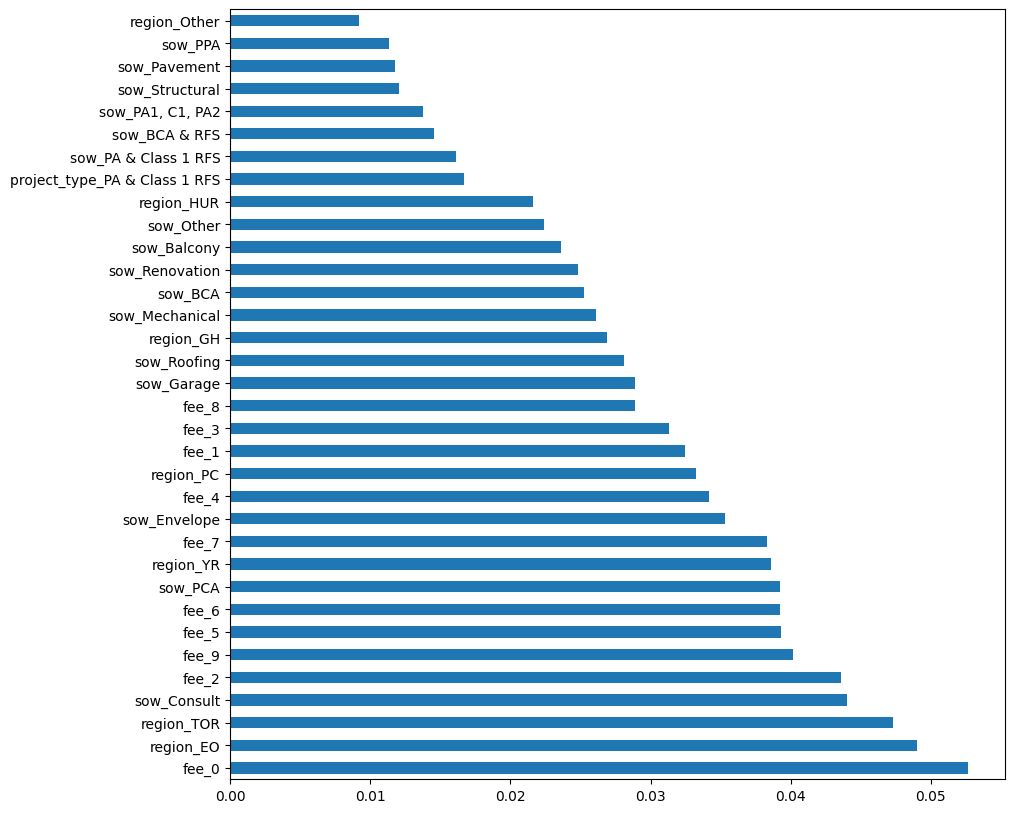

In [ ]:
importances_rf = pd.Series(rf_all.feature_importances_,
                           index=X_train_all.columns).sort_values(ascending=False)

importances_rf.plot(kind='barh', figsize=(10,10))

# **Non-RFS Model - Gradient Boosting**

This will give us one really solid decision tree which would be great from an explainability standpoint

In [ ]:
def train_GB (est, max_depth, lr):
  gb = GradientBoostingClassifier(n_estimators=est, max_depth=max_depth, learning_rate=lr, random_state=37)
  gb_all = gb.fit(X_train_all, y_train_all)
  y_pred_all = gb_all.predict(X_test_all)
  precision, recall, fscore, support = precision_recall_fscore_support(y_test_all, y_pred_all, average='binary')
  print('Est: {} / Depth: {} / LR: {} --- Precision: {} / Recall: {} / Accuracy: {}'.format(
      est, max_depth, lr, round(precision, 3), round(recall, 3),
      round((y_pred_all==y_test_all).sum() / len(y_pred_all), 3)))

The best results are seen with:
*   Est: 50, 100 and 150
*   Depth: 7 and 10
*   LR: 0.1 and 1

We'll test these further with GridSearch

In [ ]:
for n_est in [50, 100, 150]:
  for max_depth in [3, 7, 10, 15]:
    for lr in [0.01, 0.1, 1]:
      train_GB(n_est, max_depth, lr)

Est: 50 / Depth: 3 / LR: 0.01 --- Precision: 0.509 / Recall: 0.97 / Accuracy: 0.522
Est: 50 / Depth: 3 / LR: 0.1 --- Precision: 0.599 / Recall: 0.76 / Accuracy: 0.629
Est: 50 / Depth: 3 / LR: 1 --- Precision: 0.643 / Recall: 0.713 / Accuracy: 0.662
Est: 50 / Depth: 7 / LR: 0.01 --- Precision: 0.547 / Recall: 0.898 / Accuracy: 0.582
Est: 50 / Depth: 7 / LR: 0.1 --- Precision: 0.632 / Recall: 0.76 / Accuracy: 0.662
Est: 50 / Depth: 7 / LR: 1 --- Precision: 0.64 / Recall: 0.713 / Accuracy: 0.659
Est: 50 / Depth: 10 / LR: 0.01 --- Precision: 0.562 / Recall: 0.892 / Accuracy: 0.602
Est: 50 / Depth: 10 / LR: 0.1 --- Precision: 0.618 / Recall: 0.737 / Accuracy: 0.644
Est: 50 / Depth: 10 / LR: 1 --- Precision: 0.638 / Recall: 0.719 / Accuracy: 0.659
Est: 50 / Depth: 15 / LR: 0.01 --- Precision: 0.575 / Recall: 0.826 / Accuracy: 0.611
Est: 50 / Depth: 15 / LR: 0.1 --- Precision: 0.636 / Recall: 0.701 / Accuracy: 0.653
Est: 50 / Depth: 15 / LR: 1 --- Precision: 0.651 / Recall: 0.725 / Accuracy: 

Based on the below results, we'll use GB with:
*   learning_rate = 1
*   n_estimators = 150
*   max_depth = 7

In [ ]:
gb_all = GradientBoostingClassifier()
param = {'n_estimators': [50, 100, 150],
         'max_depth': [7, 10],
         'learning_rate': [0.1, 1]}

gs_gb_all = GridSearchCV(gb_all, param, cv=5)
cv_gb_all = gs_gb_all.fit(X_train_all, y_train_all)

pd.DataFrame(cv_gb_all.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.724071,0.008568,0.004763,0.000342,0.1,10,100,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.617100,0.624535,0.598513,0.568773,0.657993,0.613383,0.029460,1
5,1.111948,0.096510,0.005547,0.000612,0.1,10,150,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.609665,0.609665,0.609665,0.557621,0.672862,0.611896,0.036545,2
11,1.335844,0.243178,0.007140,0.002319,1.0,10,150,"{'learning_rate': 1, 'max_depth': 10, 'n_estim...",0.598513,0.620818,0.617100,0.553903,0.661710,0.610409,0.034984,3
0,0.223498,0.010207,0.003584,0.000306,0.1,7,50,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",0.598513,0.605948,0.617100,0.572491,0.654275,0.609665,0.026704,4
3,0.422083,0.098641,0.004375,0.000889,0.1,10,50,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.594796,0.620818,0.602230,0.572491,0.650558,0.608178,0.026244,5


Lets take a quick look at the resulting tree

In [ ]:
gb_all_final = GradientBoostingClassifier(n_estimators=150, max_depth=7, learning_rate=1, random_state=37)
gb_all_final.fit(X_train_all, y_train_all)
y_pred_all = gb_all_final.predict(X_test_all)

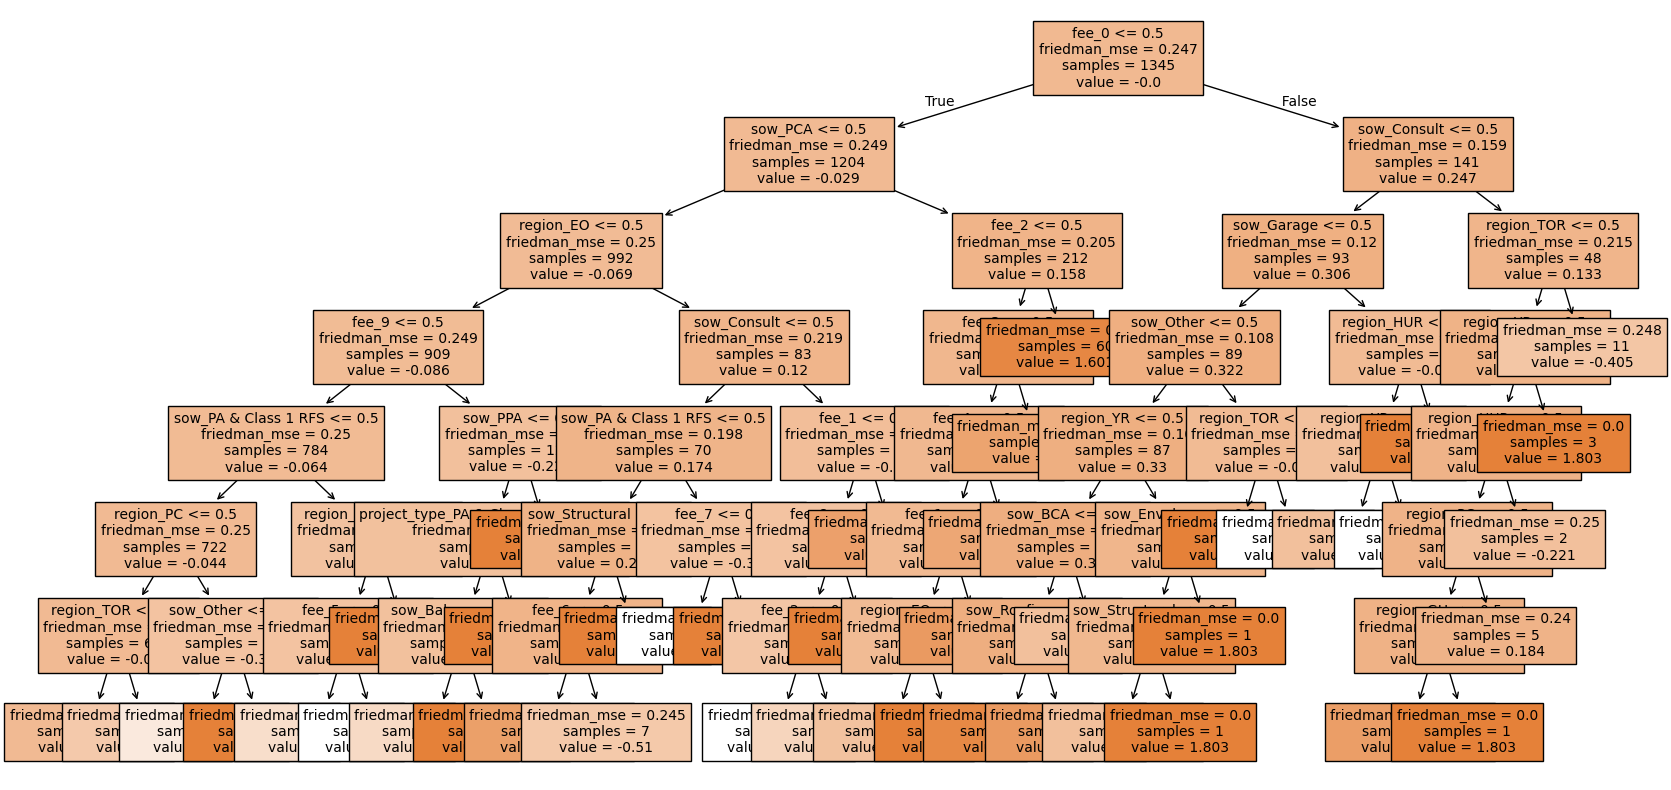

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(gb_all_final.estimators_[0, 0], filled=True, feature_names=X_train_all.columns, fontsize=10)
plt.show()

In [ ]:
precision, recall, fscore, train_support = precision_recall_fscore_support(y_test_all, y_pred_all, pos_label=1, average='binary')

print('Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3), round(recall, 3), round((y_pred_all==y_test_all).sum()/len(y_pred_all), 3)))

Precision: 0.636 / Recall: 0.701 / Accuracy: 0.653


# **Non-RFS - KNN**

In [ ]:
train_accuracies = {}
test_accuracies = {}

neighbors = np.arange(1,26)
for k in neighbors:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train_all, y_train_all)
  train_accuracies[k] = knn.score(X_train_all, y_train_all)
  test_accuracies[k] = knn.score(X_test_all, y_test_all)

There is a lot of fluctuation in model accuracy based on k. We'll use k=4

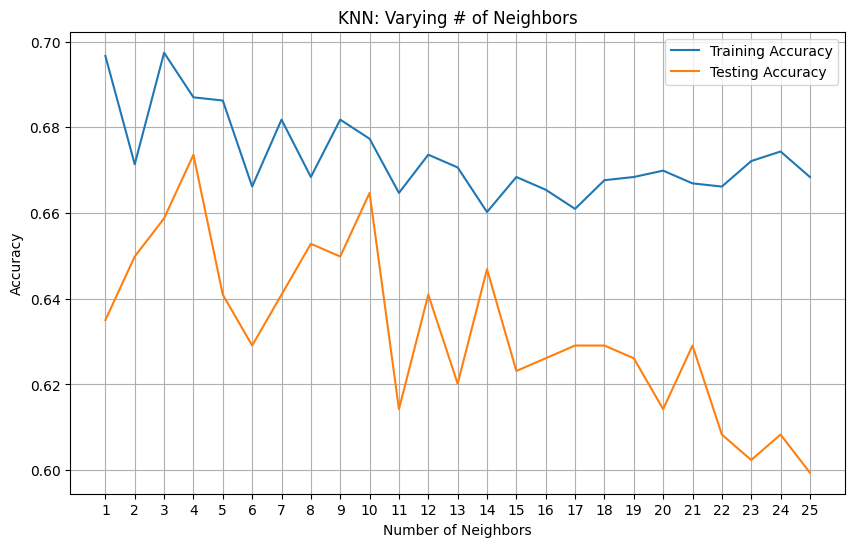

In [ ]:
plt.figure(figsize=(10,6))
plt.title('KNN: Varying # of Neighbors')
plt.plot(neighbors, train_accuracies.values(), label='Training Accuracy')
plt.plot(neighbors, test_accuracies.values(), label='Testing Accuracy')

plt.grid(True)
plt.xticks(neighbors)

plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

The accuracy is about 5% below where we are with logistic regression

In [ ]:
knn_all = KNeighborsClassifier(n_neighbors=4)
knn_all.fit(X_train_all, y_train_all)
y_pred_knn_all = knn_all.predict(X_test_all)

print('Score: ', knn_all.score(X_test_all, y_test_all))

Score:  0.6735905044510386


# **RFS Model - Logistic Regression**

In [ ]:
logreg = LogisticRegression()

param_grid = {
    'C': [0.1, 1.0, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'max_iter': [100, 150, 200],
}

grid_search = GridSearchCV(logreg, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_rfs, y_train_rfs)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}


In [ ]:
logreg = LogisticRegression(C=0.1, max_iter=100, penalty='l2', solver='liblinear')
logreg.fit(X_train_rfs, y_train_rfs)
y_pred_logreg_rfs = logreg.predict(X_test_rfs)
y_pred_logreg_rfs_probs = logreg.predict_proba(X_test_rfs)
y_pred_logreg_rfs_probs = y_pred_logreg_rfs_probs[:,1]

We're not quite able to crack the 70% mark, with the model scoring 68%

AUC Score: 0.678190


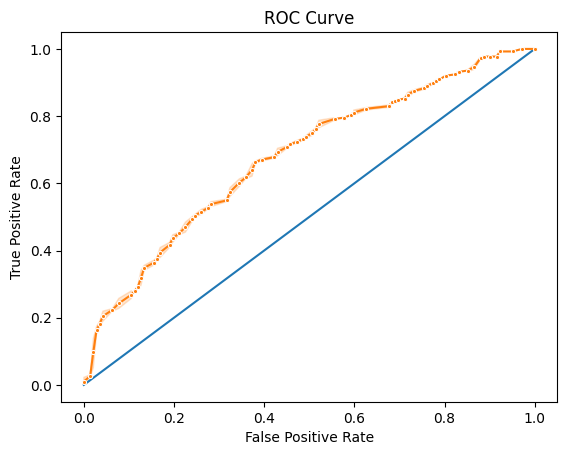

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_rfs, y_pred_logreg_rfs_probs)
sns.lineplot(x=[0,1], y=[0,1], linestyle='-')
ax = sns.lineplot(x=fpr, y=tpr, marker = '.')
ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

auc_score = roc_auc_score(y_test_rfs, y_pred_logreg_rfs_probs)
print('AUC Score: %3f' %auc_score)

In [ ]:
confusion_matrix(y_test_rfs, y_pred_logreg_rfs)

array([[98, 44],
       [62, 70]])

In [ ]:
print('Precision: ', precision_score(y_test_rfs, y_pred_logreg_rfs))
print('Recall: ', recall_score(y_test_rfs, y_pred_logreg_rfs))

Precision:  0.6140350877192983
Recall:  0.5303030303030303


In [ ]:
coefficients = logreg.coef_[0]
feature_names = X_train_rfs.columns

coeff_df_rfs = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

coeff_df_rfs['Abs_Coefficient'] = coeff_df_rfs['Coefficient'].abs()
coeff_df_rfs = coeff_df_rfs.sort_values(by='Abs_Coefficient', ascending=False)

print(coeff_df_rfs)

                 Feature  Coefficient  Abs_Coefficient
0               prev_rfs     1.846701         1.846701
1               reminder    -1.231590         1.231590
29          unit_bin_9.0    -0.937500         0.937500
19      building_unknown    -0.859826         0.859826
4        sow_Class 3 RFS     0.825727         0.825727
28          unit_bin_8.0    -0.479561         0.479561
27          unit_bin_7.0    -0.446463         0.446463
11            region_TOR    -0.416009         0.416009
15    building_mixed_use    -0.414722         0.414722
13   building_commercial     0.352745         0.352745
31           fee_bin_1.0    -0.334794         0.334794
18    building_townhouse    -0.322331         0.322331
3        sow_Class 2 RFS    -0.272219         0.272219
35           fee_bin_5.0     0.270367         0.270367
8             region_HUR     0.263257         0.263257
23          unit_bin_3.0     0.201757         0.201757
39           fee_bin_9.0    -0.188581         0.188581
26        

# **RFS Model - Gradient Boosting**

In [ ]:
def train_GB (est, max_depth, lr):
  gb = GradientBoostingClassifier(n_estimators=est, max_depth=max_depth, learning_rate=lr, random_state=37)
  gb_rfs = gb.fit(X_train_rfs, y_train_rfs)
  y_pred_rfs = gb_rfs.predict(X_test_rfs)
  precision, recall, fscore, support = precision_recall_fscore_support(y_test_rfs, y_pred_rfs, average='binary')
  print('Est: {} / Depth: {} / LR: {} --- Precision: {} / Recall: {} / Accuracy: {}'.format(
      est, max_depth, lr, round(precision, 3), round(recall, 3),
      round((y_pred_rfs==y_test_rfs).sum() / len(y_pred_rfs), 3)))

Best initial results are seen with:
*   n_estimators: 100, 150
*   max_depth: 3, 10
*   learning_rate: 0.01, 0.1

In [ ]:
for n_est in [50, 100, 150]:
  for max_depth in [3, 7, 10, 15]:
    for lr in [0.01, 0.1, 1]:
      train_GB(n_est, max_depth, lr)

Est: 50 / Depth: 3 / LR: 0.01 --- Precision: 0.634 / Recall: 0.447 / Accuracy: 0.609
Est: 50 / Depth: 3 / LR: 0.1 --- Precision: 0.628 / Recall: 0.538 / Accuracy: 0.624
Est: 50 / Depth: 3 / LR: 1 --- Precision: 0.556 / Recall: 0.53 / Accuracy: 0.569
Est: 50 / Depth: 7 / LR: 0.01 --- Precision: 0.571 / Recall: 0.394 / Accuracy: 0.566
Est: 50 / Depth: 7 / LR: 0.1 --- Precision: 0.556 / Recall: 0.53 / Accuracy: 0.569
Est: 50 / Depth: 7 / LR: 1 --- Precision: 0.594 / Recall: 0.576 / Accuracy: 0.606
Est: 50 / Depth: 10 / LR: 0.01 --- Precision: 0.535 / Recall: 0.402 / Accuracy: 0.544
Est: 50 / Depth: 10 / LR: 0.1 --- Precision: 0.587 / Recall: 0.561 / Accuracy: 0.599
Est: 50 / Depth: 10 / LR: 1 --- Precision: 0.584 / Recall: 0.606 / Accuracy: 0.602
Est: 50 / Depth: 15 / LR: 0.01 --- Precision: 0.546 / Recall: 0.492 / Accuracy: 0.558
Est: 50 / Depth: 15 / LR: 0.1 --- Precision: 0.551 / Recall: 0.568 / Accuracy: 0.569
Est: 50 / Depth: 15 / LR: 1 --- Precision: 0.568 / Recall: 0.568 / Accuracy

Based on the GridSearch results, our final GradientBoosting params will be:
*   n_estimators: 150
*   max_depth: 3
*   learning_rate = 0.1



In [ ]:
gb_rfs = GradientBoostingClassifier()
param = {'n_estimators': [100, 150],
         'max_depth': [3, 10],
         'learning_rate': [0.01, 0.1]}

gs_gb_rfs = GridSearchCV(gb_rfs, param, cv=5)
cv_gb_rfs = gs_gb_rfs.fit(X_train_rfs, y_train_rfs)

pd.DataFrame(cv_gb_rfs.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.310405,0.005058,0.003683,0.000074,0.10,3,150,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.686364,0.703196,0.643836,0.703196,0.662100,0.679738,0.023429,1
4,0.205283,0.001939,0.003830,0.000829,0.10,3,100,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.681818,0.716895,0.630137,0.684932,0.666667,0.676090,0.028201,2
0,0.315140,0.005927,0.005593,0.000727,0.01,3,100,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.686364,0.680365,0.598174,0.662100,0.634703,0.652341,0.032506,3
1,0.342524,0.069529,0.004506,0.000897,0.01,3,150,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.686364,0.680365,0.593607,0.652968,0.639269,0.650515,0.033308,4
3,1.953170,0.412439,0.006669,0.001178,0.01,10,150,"{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",0.659091,0.657534,0.634703,0.675799,0.598174,0.645060,0.026844,5


In [ ]:
gb_rfs_final = GradientBoostingClassifier(n_estimators=150, max_depth=3, learning_rate=0.1, random_state=37)
gb_rfs_final.fit(X_train_rfs, y_train_rfs)
y_pred_rfs = gb_rfs_final.predict(X_test_rfs)

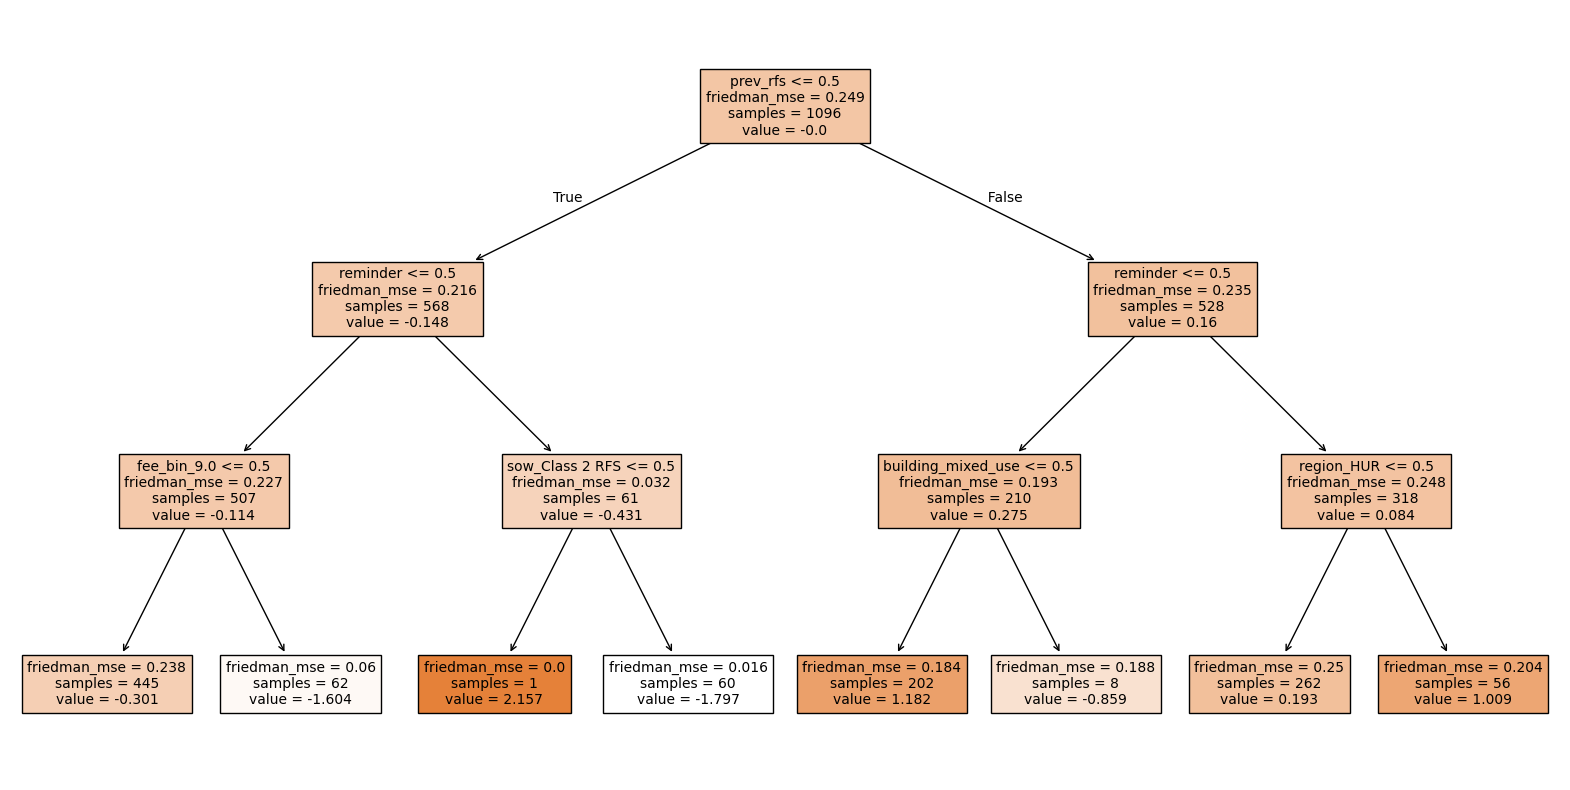

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(gb_rfs_final.estimators_[0, 0], filled=True, feature_names=X_train_rfs.columns, fontsize=10)
plt.show()

In [ ]:
precision, recall, fscore, train_support = precision_recall_fscore_support(y_test_rfs, y_pred_rfs, pos_label=1, average='binary')

print('Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3), round(recall, 3), round((y_pred_rfs==y_test_rfs).sum()/len(y_pred_rfs), 3)))

Precision: 0.586 / Recall: 0.515 / Accuracy: 0.591


# **RFS Model - KNN**

Our results using the preferred easily interpretable model types have not yielded strong results so we'll try knn

In [ ]:
train_accuracies = {}
test_accuracies = {}

neighbors = np.arange(1,26)
for k in neighbors:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train_rfs, y_train_rfs)
  train_accuracies[k] = knn.score(X_train_rfs, y_train_rfs)
  test_accuracies[k] = knn.score(X_test_rfs, y_test_rfs)

The testing accuracy is consistenly low for all values of k tested. There is a small jump at k=20, but the gain in accuracy is not enough to make this model viable

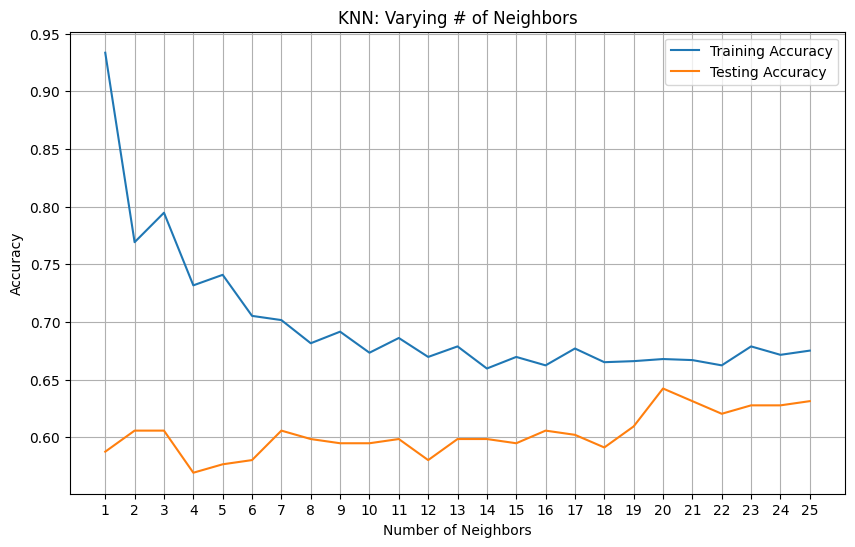

In [ ]:
plt.figure(figsize=(10,6))
plt.title('KNN: Varying # of Neighbors')
plt.plot(neighbors, train_accuracies.values(), label='Training Accuracy')
plt.plot(neighbors, test_accuracies.values(), label='Testing Accuracy')

plt.grid(True)
plt.xticks(neighbors)

plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

With k=20 we have an accuracy of 64%. Logistic regression is still our best model type

In [ ]:
knn_rfs = KNeighborsClassifier(n_neighbors=20)
knn_rfs.fit(X_train_rfs, y_train_rfs)
y_pred_knn_rfs = knn_rfs.predict(X_test_rfs)

print('Score: ', knn_rfs.score(X_test_rfs, y_test_rfs))

Score:  0.6423357664233577
